In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import joblib
from pickle import dump

%matplotlib inline

In [2]:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.gaussian_process.kernels import RBF

# Training 1

In [3]:
df_training =  pd.read_csv("training_set_v1_dr7.csv")
columnsNamesArr = df_training.columns.values
column_names = list(columnsNamesArr)
print(column_names[1:])

['ra', 'dec', 'g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'concentration_index', 'photo_z', 'frac_dev', 'host_galaxy', 'distance', 'axis_ratio', 'category', 'radius', 'magnitude', 'u_mag', 'g_mag', 'i_mag', 'r_mag', 'z_mag', 'link']


In [4]:
features = ['g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'concentration_index', 'photo_z', 'frac_dev','axis_ratio','radius', 'magnitude']
print(len(features))

11


In [5]:
# classification as array of 0's and 1's
category = df_training['category']
classification = np.NaN*np.ones(len(category))
classification[category == 'Known galaxies'] = 1  
classification[category == 'Contaminant'] = 0 
print(len(classification))
print(len(classification[classification == 1]))

163
18


In [6]:
# define feature data and standardize it
data = df_training.loc[:,features].values
# define scaler
# scaler = StandardScaler()
scaler = RobustScaler()
# scaler = QuantileTransformer()
# fit scaler on the training dataset
scaler.fit(data)
# transform the training dataset
data_scaled = scaler.transform(data)

In [7]:
# transform data to 6 principle components which take into account 95 pct of the variance in the data
pca = PCA(n_components = 11, random_state = 2020)
pca.fit(data_scaled)
# pca = PCA(n_components = 0.95, random_state = 2020) this automatically chooses the amount of PC's for 95 pct variance
principal_components = pca.transform(data_scaled)
principal_df = pd.DataFrame(data = principal_components, columns = ['Principal Component 1','Principal Component 2','Principal Component 3','Principal Component 4','Principal Component 5','Principal Component 6','Principal Component 7','Principal Component 8','Principal Component 9','Principal Component 10','Principal Component 11'])
final_df = pd.concat([principal_df, df_training[['category']]], axis = 1)


Text(0.5, 1.0, 'Influence on each principal component by features')

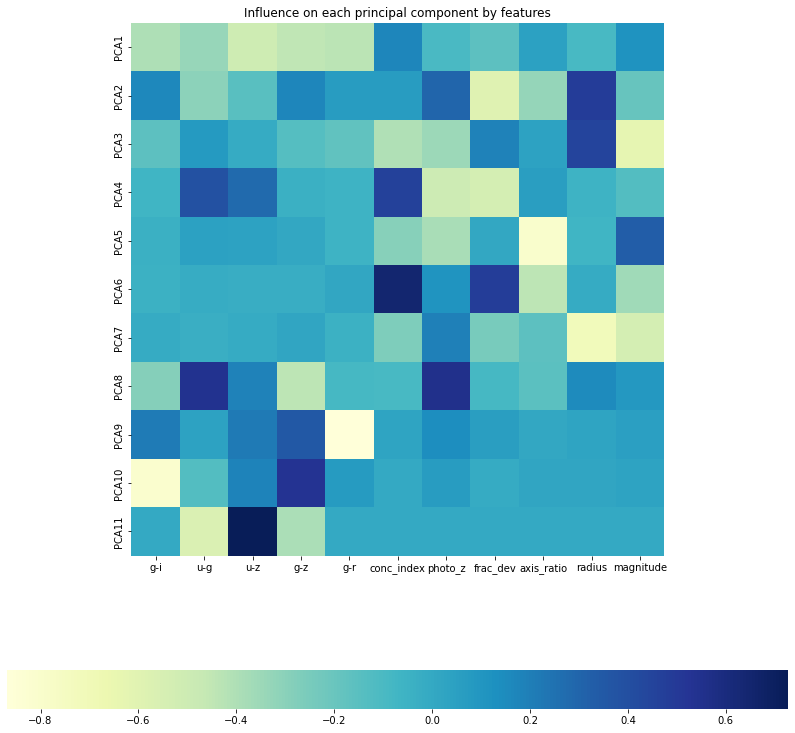

In [8]:
features_map = ['g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'conc_index', 'photo_z', 'frac_dev', 'axis_ratio','radius', 'magnitude']
fig = plt.figure(figsize = (14,14))
ax = sns.heatmap(pca.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=features_map,
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")
ax.set_title('Influence on each principal component by features')

In [9]:
# X = principal_components
# y = classification

In [10]:
X = data_scaled
y = classification

In [11]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('GP', GaussianProcessClassifier()))
models.append(('RF', RandomForestClassifier(max_depth=None, n_estimators=100, max_features= 'auto')))
models.append(('MLP', MLPClassifier(activation='relu', solver='lbfgs', max_iter=200)))
models.append(('PRCP', Perceptron(random_state= 1, max_iter=30, tol = 0.001)))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=4, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X, y, cv=kfold, scoring='recall')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# try neural network

LR: 0.837500 (0.170935)
LDA: 0.787500 (0.245904)
KNN: 0.512500 (0.201168)
CART: 0.787500 (0.143069)
NB: 0.750000 (0.306186)
SVM: 0.725000 (0.277263)
GP: 0.737500 (0.163459)
RF: 0.600000 (0.215058)
MLP: 0.825000 (0.103078)
PRCP: 0.775000 (0.143614)


In [12]:
# voting methods application
clf1 = LogisticRegression(solver='liblinear', multi_class='ovr')
clf2 = LinearDiscriminantAnalysis()
clf3 = KNeighborsClassifier()
clf4 = DecisionTreeClassifier()
clf5 = GaussianNB()
clf6 = GaussianProcessClassifier()
clf7 = SVC(gamma='auto')
clf8 = RandomForestClassifier(max_depth=None, n_estimators=100, max_features= 'auto')
clf9 = MLPClassifier(activation='relu', solver='lbfgs', max_iter=100000)
clf10 = Perceptron(random_state= 1, max_iter=30, tol = 0.001)

eclf1 = VotingClassifier(estimators=[('LR', clf1), ('CART', clf4), ('GP', clf6), ('MLP', clf9)], voting='hard')
eclf1.fit(X, y)
eclf_predict = eclf1.predict(X)

In [13]:
# save the model
dump(eclf1, open('voting_model_PCA_v1_dr7.pkl', 'wb'))
# save the scaler
dump(scaler, open('scaler_voting_model_PCA_v1_dr7.pkl', 'wb'))
# save the pca
dump(pca, open('pca_model_PCA_v1_dr7.pkl', 'wb'))

In [14]:
plt.rcParams.update({'font.size': 20})

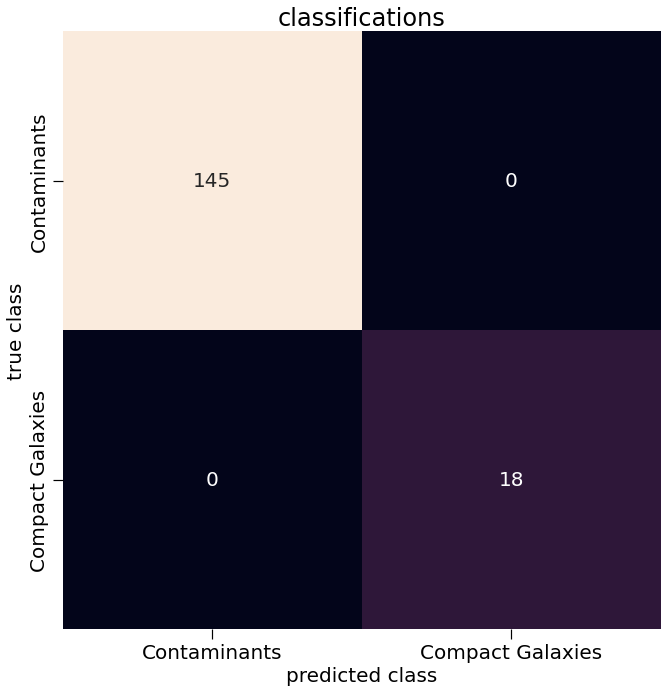

In [15]:
fig1 = plt.figure(figsize=(11,11))
g = sns.heatmap(confusion_matrix(y, eclf_predict), square=True, annot=True, fmt="d", cbar=False, xticklabels=['Contaminants', 'Compact Galaxies'], yticklabels=['Contaminants', 'Compact Galaxies'])
g.set_yticklabels(labels=g.get_yticklabels(), va='center')
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.title('classifications')
plt.tick_params('both', length=10, width=1.2, which='major', labelsize=20)

# Training 2

In [3]:
df_training_2 =  pd.read_csv("training_set_v2_dr7.csv")
columnsNamesArr_2 = df_training_2.columns.values
column_names_2 = list(columnsNamesArr_2)
print(column_names_2[1:])

['objid', 'ra', 'dec', 'g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'concentration_index', 'photo_z', 'frac_dev', 'host_galaxy', 'distance', 'axis_ratio', 'category', 'radius', 'magnitude', 'u_mag', 'g_mag', 'i_mag', 'r_mag', 'z_mag', 'link']


In [4]:
features_2 = ['g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'concentration_index', 'photo_z', 'frac_dev','axis_ratio','radius', 'magnitude']
print(len(features_2))

11


In [5]:
# classification as array of 0's and 1's
category_2 = df_training_2['category']
classification_2 = np.NaN*np.ones(len(category_2))
classification_2[category_2 == 'Known galaxies'] = 1  
classification_2[category_2 == 'Contaminant'] = 0 
print(len(classification_2))

341


In [6]:
# define feature data and standardize it
data_2 = df_training_2.loc[:,features_2].values
# define scaler
# scaler_2 = StandardScaler()
scaler_2 = RobustScaler()
# scaler_2 = QuantileTransformer()
# fit scaler on the training dataset
scaler_2.fit(data_2)
# transform the training dataset
data_scaled_2 = scaler_2.transform(data_2)

In [7]:
# transform data to 6 principle components which take into account 95 pct of the variance in the data
pca_2 = PCA(n_components = 11, random_state = 2020)
# pca_2 = PCA(n_components = 0.95, random_state = 2020) #this automatically chooses the amount of PC's for 95 pct variance

pca_2.fit(data_scaled_2)
principal_components_2 = pca_2.transform(data_scaled_2)
principal_df_2 = pd.DataFrame(data = principal_components_2, columns = ['Principal Component 1','Principal Component 2','Principal Component 3','Principal Component 4','Principal Component 5','Principal Component 6','Principal Component 7','Principal Component 8','Principal Component 9','Principal Component 10','Principal Component 11'])
final_df_2 = pd.concat([principal_df_2, df_training_2[['category']]], axis = 1)

In [8]:
plt.rcParams.update({'font.size': 15})

Text(0.5, 1.0, 'Influence on each principal component by features')

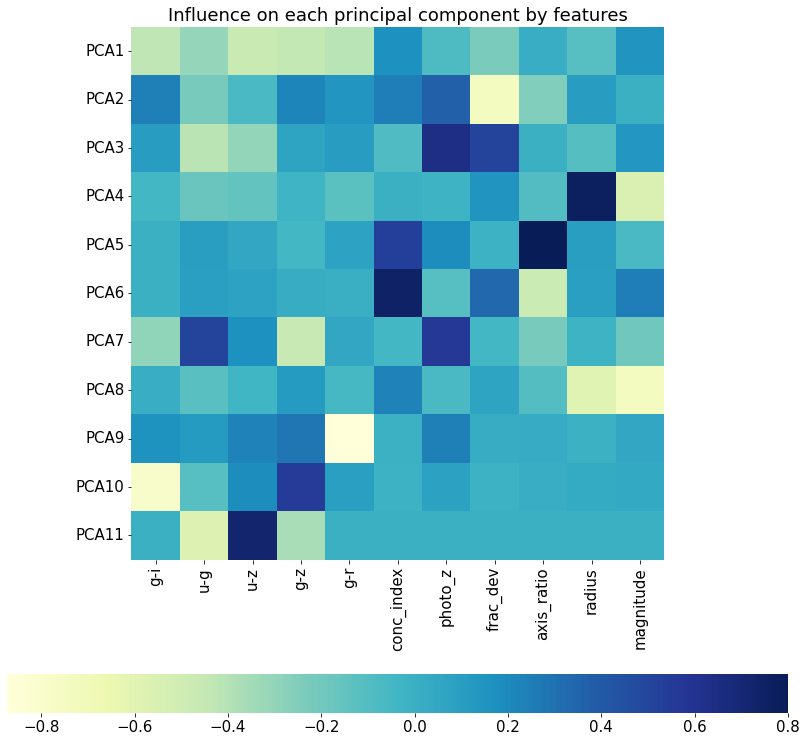

In [9]:
features_map = ['g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'conc_index', 'photo_z', 'frac_dev', 'axis_ratio','radius', 'magnitude']
fig = plt.figure(figsize = (14,14))
ax = sns.heatmap(pca_2.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca_2.n_components_+1)],
                 xticklabels=features_map,
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")
ax.set_title('Influence on each principal component by features')

In [10]:
X_2 = principal_components_2
y_2 = classification_2

In [11]:
# X_2 = data_scaled_2
# y_2 = classification_2

In [12]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('GP', GaussianProcessClassifier()))
models.append(('RF', RandomForestClassifier(max_depth=None, n_estimators=100, max_features= 'auto')))
models.append(('MLP', MLPClassifier(activation='relu', solver='lbfgs', max_iter=500)))
models.append(('PRCP', Perceptron(random_state= 1, max_iter=30, tol = 0.001)))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=4, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_2, y_2, cv=kfold, scoring='recall')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# try neural network

LR: 0.762500 (0.178098)
LDA: 0.737500 (0.216145)
KNN: 0.562500 (0.129301)
CART: 0.512500 (0.320887)
NB: 0.675000 (0.192029)
SVM: 0.600000 (0.215058)
GP: 0.737500 (0.163459)
RF: 0.350000 (0.206155)
MLP: 0.825000 (0.204634)
PRCP: 0.762500 (0.306951)


In [13]:
# voting methods application
clf1 = LogisticRegression(solver='liblinear', multi_class='ovr')
clf2 = LinearDiscriminantAnalysis()
clf3 = KNeighborsClassifier()
clf4 = DecisionTreeClassifier()
clf5 = GaussianNB()
clf6 = GaussianProcessClassifier()
clf7 = SVC(gamma='auto')
clf8 = RandomForestClassifier(max_depth=None, n_estimators=100, max_features= 'auto')
clf9 = MLPClassifier(activation='relu', solver='lbfgs', max_iter=100000)
clf10 = Perceptron(random_state= 1, max_iter=30, tol = 0.001)

eclf2 = VotingClassifier(estimators=[('LR', clf1),('GP',clf6),('LDA',clf2),('NB', clf5), ('CART', clf4), ('MLP', clf9)], voting='soft')
eclf2.fit(X_2, y_2)
eclf2_predict = eclf2.predict(X_2)

In [14]:
plt.rcParams.update({'font.size': 20})

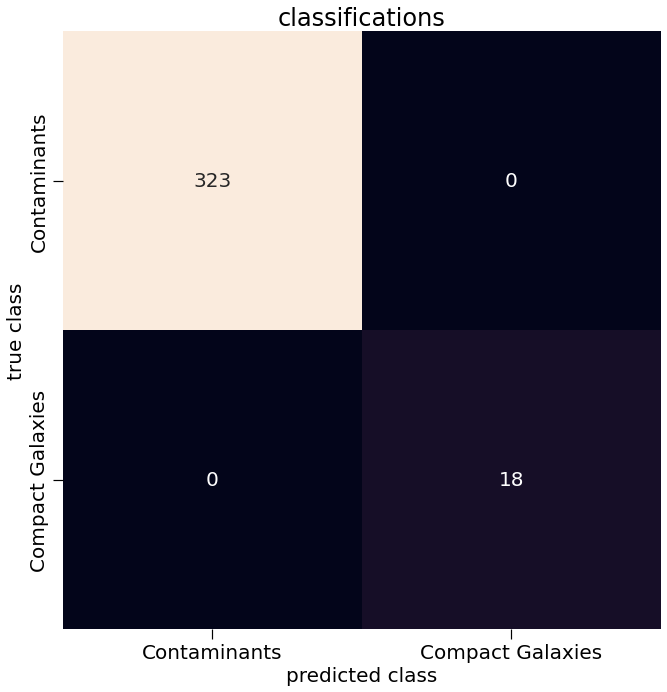

In [15]:
fig1 = plt.figure(figsize=(11,11))
g = sns.heatmap(confusion_matrix(y_2, eclf2_predict), square=True, annot=True, fmt="d", cbar=False, xticklabels=['Contaminants', 'Compact Galaxies'], yticklabels=['Contaminants', 'Compact Galaxies'])
g.set_yticklabels(labels=g.get_yticklabels(), va='center')
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.title('classifications')
plt.tick_params('both', length=10, width=1.2, which='major', labelsize=20)

In [16]:
# save the model
dump(eclf2, open('voting_model_PCA_v2_dr7.pkl', 'wb'))
# save the scaler
dump(scaler_2, open('scaler_voting_model_PCA_v2_dr7.pkl', 'wb'))
# save the pca
dump(pca_2, open('pca_model_PCA_v2_dr7.pkl', 'wb'))